# RIVeR Tutorial 1: Video to Frames Extraction

This notebook demonstrates how to convert river flow videos into individual frames for further processing using the RIVeR package. Frame extraction is the first crucial step in our river flow analysis pipeline.

## Why Extract Frames?
- PIV analysis requires sequential image pairs
- Easier memory management than processing full videos
- Allows for quality control and frame selection
- Enables parallel processing in later steps

## Prerequisites
- RIVeR package installed
- Video file(s) of river flow
- Sufficient storage space for frames (tip: estimate ~0.5-2MB per frame)

In [1]:
# Import required libraries
from pathlib import Path
import numpy as np
import cv2
from tqdm.notebook import tqdm

# Import RIVeR modules
from river.core.video_to_frames import video_to_frames
from river.core.exceptions import VideoHasNoFrames

# Enable better error messages
import warnings
warnings.filterwarnings('always')

## Step 1: Setting Up Your Directory Structure

First, we'll create a organized directory structure for our project. This keeps our raw data, processed frames, and results well-organized.

In [2]:
# Define project directories
root_dir = Path.cwd()  # or specify your project root
data_dir = root_dir / "data"
video_dir = data_dir / "videos"
frames_dir = data_dir / "frames"

# Create directories if they don't exist
frames_dir.mkdir(parents=True, exist_ok=True)

print(f"Project structure created at: {root_dir}")
print(f"Frames will be saved to: {frames_dir}")

Project structure created at: /Users/antoine/river-jupyter/examples
Frames will be saved to: /Users/antoine/river-jupyter/examples/data/frames


In [3]:
def check_video_info(video_path: Path) -> dict:
    """Check video properties and estimate storage requirements."""
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")
    
    try:
        # Get video properties
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        # Read one frame to estimate size
        ret, frame = cap.read()
        if not ret:
            raise VideoHasNoFrames("Could not read frames from video")
            
        frame_size_mb = frame.nbytes / (1024 * 1024)  # Size in MB
        total_size_gb = (frame_size_mb * total_frames) / 1024  # Total size in GB
        
        return {
            "total_frames": total_frames,
            "fps": fps,
            "resolution": f"{width}x{height}",
            "estimated_size_gb": total_size_gb
        }
    finally:
        cap.release()

# Example usage
video_path = video_dir / "nadir"/ "canuelas.mp4"  # Replace with your video path
try:
    info = check_video_info(video_path)
    print("\nVideo Information:")
    for key, value in info.items():
        print(f"{key}: {value}")
except (ValueError, VideoHasNoFrames) as e:
    print(f"Error: {e}")


Video Information:
total_frames: 90
fps: 29.97002997002997
resolution: 1920x1080
estimated_size_gb: 0.5214214324951172


## Step 3: Frame Extraction

Now we'll extract frames from the video. You can specify:
- `every`: Extract every nth frame (e.g., every=2 takes every second frame)
- `start_frame_number`: Begin extraction from this frame
- `end_frame_number`: Stop extraction at this frame
- `chunk_size`: Number of frames per processing chunk (affects memory usage)

In [ ]:
# Extract frames with progress tracking
try:
    # Configuration
    extract_config = {
        "video_path": video_path,
        "frames_dir": frames_dir / video_path.stem,  # Create subfolder for frames
        "start_frame_number": 0,
        "end_frame_number": None,  # None means process all frames
        "every": 2,  # Extract every second frame
        "overwrite": False
    }
    
    # Create frames directory
    extract_config["frames_dir"].mkdir(parents=True, exist_ok=True)
    
    print("Starting frame extraction...")
    first_frame = video_to_frames(**extract_config)
    
    print(f"\nFrame extraction complete!")
    print(f"Frames saved to: {extract_config['frames_dir']}")
    print(f"First frame: {first_frame}")
    
except Exception as e:
    print(f"Error during frame extraction: {e}")

Starting frame extraction...

Frame extraction complete!
Frames saved to: /Users/antoine/river-jupyter/examples/data/frames/canuelas
First frame: /Users/antoine/river-jupyter/examples/data/frames/canuelas/0000000000.jpg


## Step 5: Visualizing Extracted Frames

Let's visualize the first extracted frame to verify the quality and content. This is a good way to check:
- Image orientation
- Resolution and clarity
- Lighting conditions
- Field of view

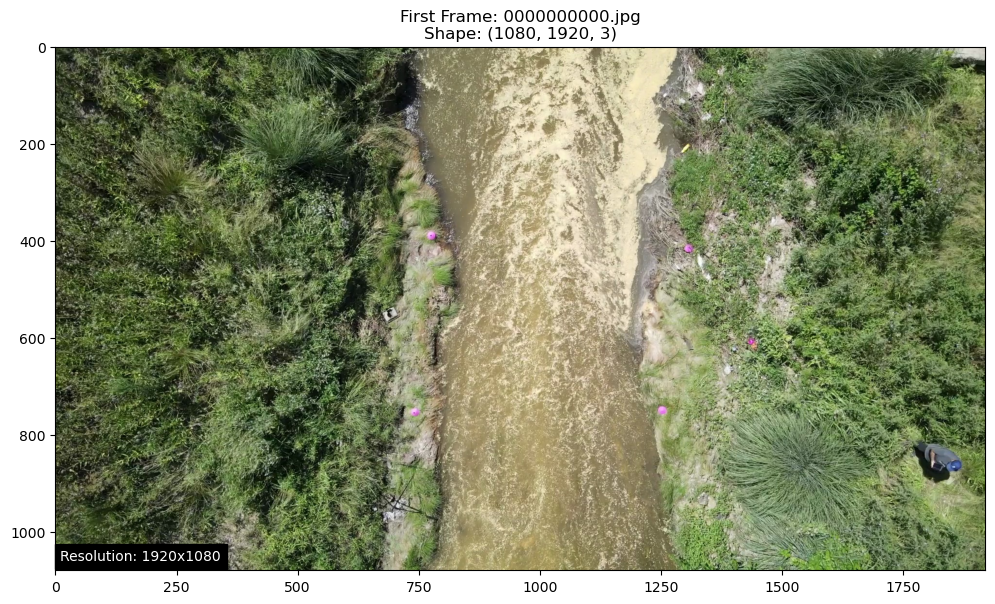

In [5]:
# Suppress deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Import and configure matplotlib
import matplotlib
matplotlib.use('Agg')  # Use Agg backend
import matplotlib.pyplot as plt
%matplotlib inline

try:
    # Read the first frame
    img = cv2.imread(str(first_frame))
    if img is None:
        raise ValueError(f"Could not read image from {first_frame}")
    
    # Convert from BGR to RGB (OpenCV uses BGR by default)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create figure with a reasonable size
    plt.figure(figsize=(12, 8))
    
    # Display the image
    plt.imshow(img_rgb)
    plt.axis('on')  # Show axes to help with dimensionality
    
    # Add title and basic image information
    plt.title(f"First Frame: {first_frame.name}\nShape: {img.shape}")
    
    # Add some grid lines to help with spatial reference
    plt.grid(False)
    
    # Display image dimensions
    height, width = img.shape[:2]
    plt.text(10, height-20, f"Resolution: {width}x{height}", 
             color='white', backgroundcolor='black', fontsize=10)
    
    plt.show()
    
except Exception as e:
    print(f"Error displaying frame: {e}")
    print("Troubleshooting tips:")
    print("1. Verify the frame path exists")
    print("2. Check if the image file is corrupted")
    print("3. Ensure you have sufficient memory to load the image")

## Common Issues and Troubleshooting

1. **Insufficient Storage Space**
   - Check available space before starting
   - Use `every` parameter to reduce number of frames
   - Consider processing in batches

2. **Memory Errors**
   - Reduce `chunk_size` parameter
   - Close other memory-intensive applications
   - Process shorter video segments

3. **Corrupted Frames**
   - Verify video file integrity
   - Try different video codec
   - Check for sufficient read/write permissions

4. **Performance Issues**
   - Adjust `chunk_size` based on your system's capabilities
   - Consider using SSD for faster I/O
   - Close unnecessary background processes

## Next Steps

After successfully extracting frames, you can proceed to:
1. Coordinate transformation (Tutorial 2)
2. PIV analysis setup (Tutorial 3)
3. Cross-section definition (Tutorial 4)